<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/UCI_dataset_RF_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt
!pip install GPy

In [5]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [7]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [8]:
#frequency distribution
for col in names: 
    print(df[col].value_counts())

#checking missing values
df.isnull().sum()

vhigh    432
high     432
med      432
low      432
Name: buying, dtype: int64
vhigh    432
high     432
med      432
low      432
Name: maint, dtype: int64
2        432
3        432
4        432
5more    432
Name: doors, dtype: int64
2       576
4       576
more    576
Name: persons, dtype: int64
small    576
med      576
big      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [9]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

df.head()
for col in names: 
    print(df[col].value_counts())

3    432
0    432
2    432
1    432
Name: buying, dtype: int64
3    432
0    432
2    432
1    432
Name: maint, dtype: int64
0    432
1    432
2    432
3    432
Name: doors, dtype: int64
0    576
1    576
2    576
Name: persons, dtype: int64
2    576
1    576
0    576
Name: lug_boot, dtype: int64
1    576
2    576
0    576
Name: safety, dtype: int64
2    1210
0     384
1      69
3      65
Name: class, dtype: int64


In [10]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [11]:
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [22]:
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  score = kfold_score(clf,X_train, y_train,10)

  print(params)
  print(score)
  return score

In [23]:
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

{'max_features': 1, 'n_estimators': 62}
0.9388154269972452
{'max_features': 1, 'n_estimators': 50}
0.9346625344352617
{'max_features': 2, 'n_estimators': 129}
0.9677548209366391
{'max_features': 4, 'n_estimators': 178}
0.9785055096418734
{'max_features': 4, 'n_estimators': 109}
0.9785055096418734
{'max_features': 3, 'n_estimators': 193}
0.9743663911845729
{'max_features': 4, 'n_estimators': 64}
0.9784986225895315
{'max_features': 4, 'n_estimators': 2}
0.9239256198347107
{'max_features': 4, 'n_estimators': 62}
0.9776859504132231
{'max_features': 3, 'n_estimators': 160}
0.9743663911845729
{'max_features': 5, 'n_estimators': 53}
0.9809848484848486
{'max_features': 2, 'n_estimators': 153}
0.9677548209366391
{'max_features': 3, 'n_estimators': 43}
0.9768526170798898
{'max_features': 3, 'n_estimators': 80}
0.976845730027548
{'max_features': 2, 'n_estimators': 46}
0.9611363636363637
{'max_features': 1, 'n_estimators': 80}
0.9437878787878787
{'max_features': 2, 'n_estimators': 195}
0.969414600

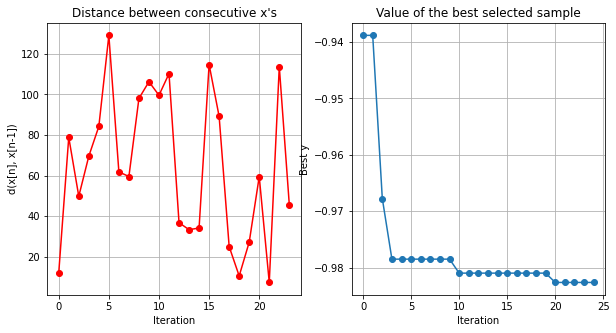

In [24]:
optimizer.plot_convergence()

In [25]:
rf_car = RandomForestClassifier(max_features=4,n_estimators=64)
rf_car.fit(X_train,y_train)
y_pred = rf_car.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9633911368015414


{'max_features': 4, 'n_estimators': 27}
0.9785055096418732
{'max_features': 4, 'n_estimators': 104}
0.9809848484848486
{'max_features': 4, 'n_estimators': 125}
0.9809848484848486
{'max_features': 4, 'n_estimators': 45}
0.9801515151515151
{'max_features': 3, 'n_estimators': 138}
0.9751997245179064
{'max_features': 1, 'n_estimators': 32}
0.9255922865013775
{'max_features': 5, 'n_estimators': 37}
0.97849173553719
{'max_features': 4, 'n_estimators': 144}
0.9793319559228651
{'max_features': 4, 'n_estimators': 28}
0.9776790633608815
{'max_features': 4, 'n_estimators': 73}
0.9785055096418734
{'max_features': 4, 'n_estimators': 3}
0.95534435261708
{'max_features': 4, 'n_estimators': 111}
0.9768526170798898
{'max_features': 4, 'n_estimators': 178}
0.9801584022038569
{'max_features': 4, 'n_estimators': 24}
0.9710674931129477
{'max_features': 4, 'n_estimators': 67}
0.9809848484848486
{'max_features': 5, 'n_estimators': 98}
0.9776790633608817
{'max_features': 5, 'n_estimators': 66}
0.9826308539944

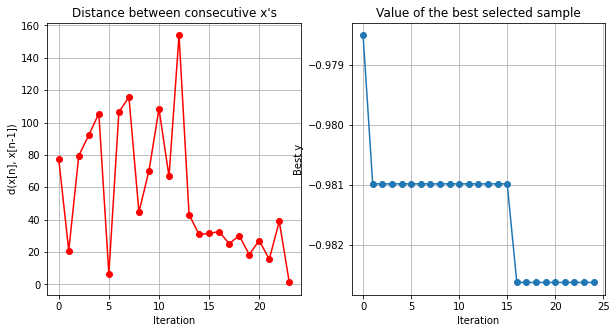

In [26]:
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

optimizer.plot_convergence()

In [27]:
rf_car2 = RandomForestClassifier(max_features=4,n_estimators=64)
rf_car2.fit(X_train,y_train)
y_pred = rf_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.9653179190751445
